# Chapter 10: Suppressing and Mitigating Quantum Noise
This Jupyter notebook has been updated to work with Python 3.12 and the following Qiskit versions:
* Qiskit v1.3, Qiskit runtime version: 0.34
* Qiskit v 2.0, Qiskit runtime version: 0.37
|||
|-|-|
|**Author:** |Robert Loredo|
|**Reviewer:** |Alain Chancé|
|**Date:** |April 12, 2025|
|**Version:** |**1.00**<br/>*Details see at the end of this notebook*|
|**References:**|
[Robert Loredo, Learn Quantum Computing with Python and IBM Quantum: Write your own practical quantum programs with Python, Second Edition, Packt, Feb 25, 2025](https://www.packtpub.com/en-us/product/learn-quantum-computing-with-python-and-ibm-quantum-9781803240923)
[Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition/Chapter 10 - Updated Qiskit 1.0.ipynb](https://github.com/AlainChance/Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition/blob/main/Chapter%2010%20-%20Updated%20Qiskit%201.0.ipynb)
[Packt's code repository for the book](https://github.com/PacktPublishing/Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition)
[LICENSE](https://github.com/PacktPublishing/Learning-Quantum-Computing-with-Python-and-IBM-Quantum-Second-Edition/blob/main/LICENSE)
[Migrate to the Qiskit Runtime V2 primitives](https://docs.quantum.ibm.com/migration-guides/v2-primitives)
[Qiskit Runtime client - Class BATCH](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/batch)
[StatevectorSampler #2219](https://github.com/Qiskit/qiskit-aer/issues/2219)
[Grover Operator](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.GroverOperator)
[grover_operator](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.grover_operator)
<br/>

In [1]:
# Load helper file
%run helper_file_1.0.ipynb

Token read from file:  Token.txt
Qiskit version: 2.0.0
Qiskit runtime version: 0.37.0
/home/alain/miniconda3/bin/python
Python 3.12.9


# Qiskit Runtime Service


In [2]:
# Create a simple circuit:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution

q_reg = QuantumRegister(4, name="qr")
c_reg = ClassicalRegister(4, name="cr")

qc = QuantumCircuit(q_reg, c_reg)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)

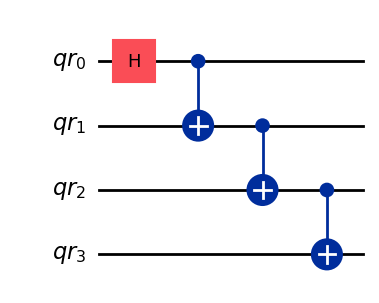

In [3]:
qc.draw(output="mpl", idle_wires=False, style="iqp")

Figure 10.1: Simple circuit to run on system

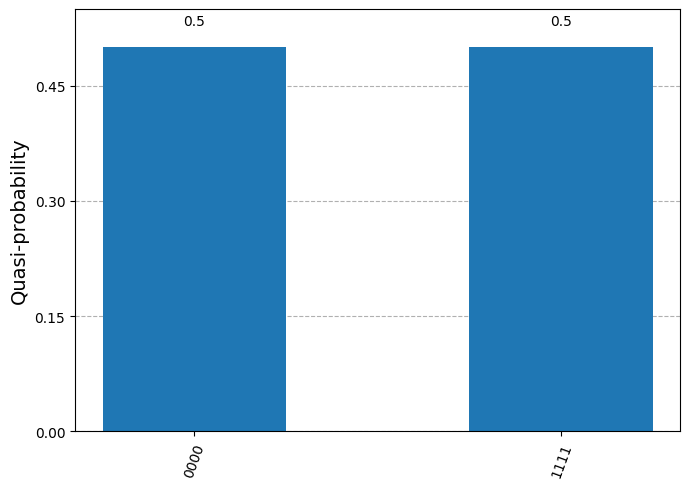

In [4]:
# A Statevector could be used to compute a circuit's expected results
from qiskit.quantum_info import Statevector

results = Statevector.from_instruction(qc).probabilities_dict()

plot_distribution(results)

Figure 10.2: Expected probability results from circuit using Statevector

In [5]:
#Add measurements to run on live system and get results: 
qc.measure_all(add_bits=False)

In [6]:
# Select the least busy backend you have access to
backend = service.least_busy(simulator=False, operational=True)
print('Least busy backend: ', backend)

Least busy backend:  <IBMBackend('ibm_kyiv')>


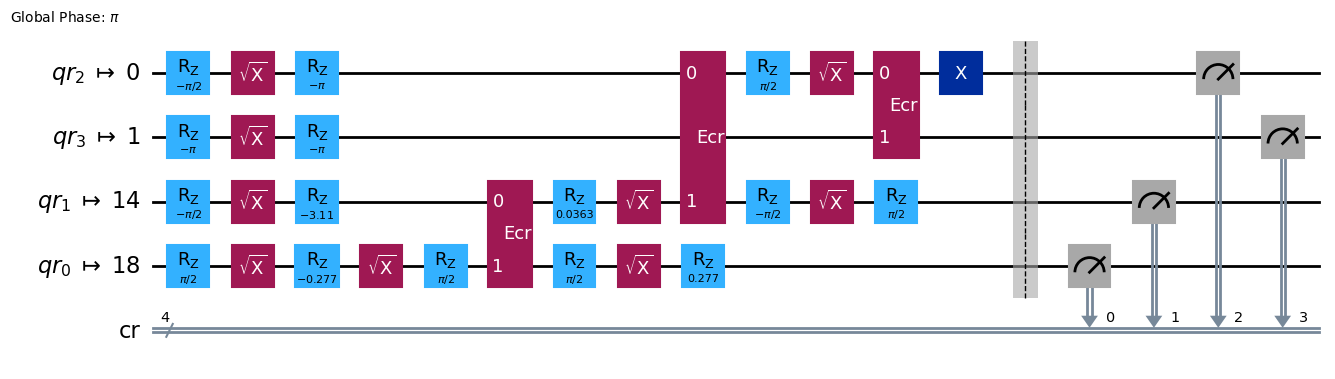

In [7]:
# Optimize for execution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

transpiled_qc = pm.run(qc)
transpiled_qc.draw(output="mpl", idle_wires=False, style="iqp")

Figure 10.3: Transpiled circuit

### Construct the Grover operator

In [8]:
# Construct the Grover operator.
# grover_operator
# https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.grover_operator

# The class qiskit.circuit.library.grover_operator.GroverOperator is pending deprecation as of qiskit 1.3. 
# It will be marked deprecated in a future release, and then removed no earlier than 3 months after the release date.
# Use qiskit.circuit.library.grover_operator instead.
# https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.GroverOperator

#from qiskit.circuit.library import GroverOperator
from qiskit.circuit.library import grover_operator

oracle = Statevector.from_label('110')
grover_op = grover_operator(oracle)

### Construct the Grover operator circuit

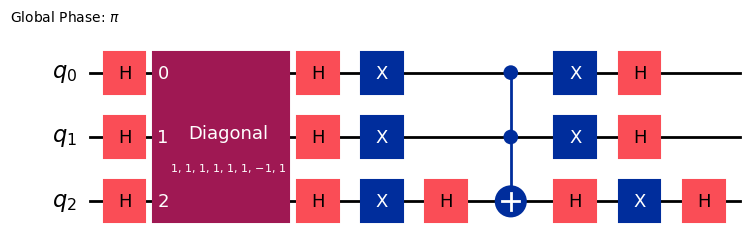

In [9]:
# Create a slightly more complex circuit using Grovers
# Modified by Alain Chancé
grover_qc = QuantumCircuit(3)
grover_qc.h(range(3))

#grover_qc = grover_qc.compose(GroverOperator(oracle))
grover_qc = grover_qc.compose(grover_op)

grover_qc.draw(output="mpl", style="iqp")

Figure 10.4: Grover Operator circuit

In [10]:
results = Statevector.from_instruction(grover_qc).probabilities_dict()

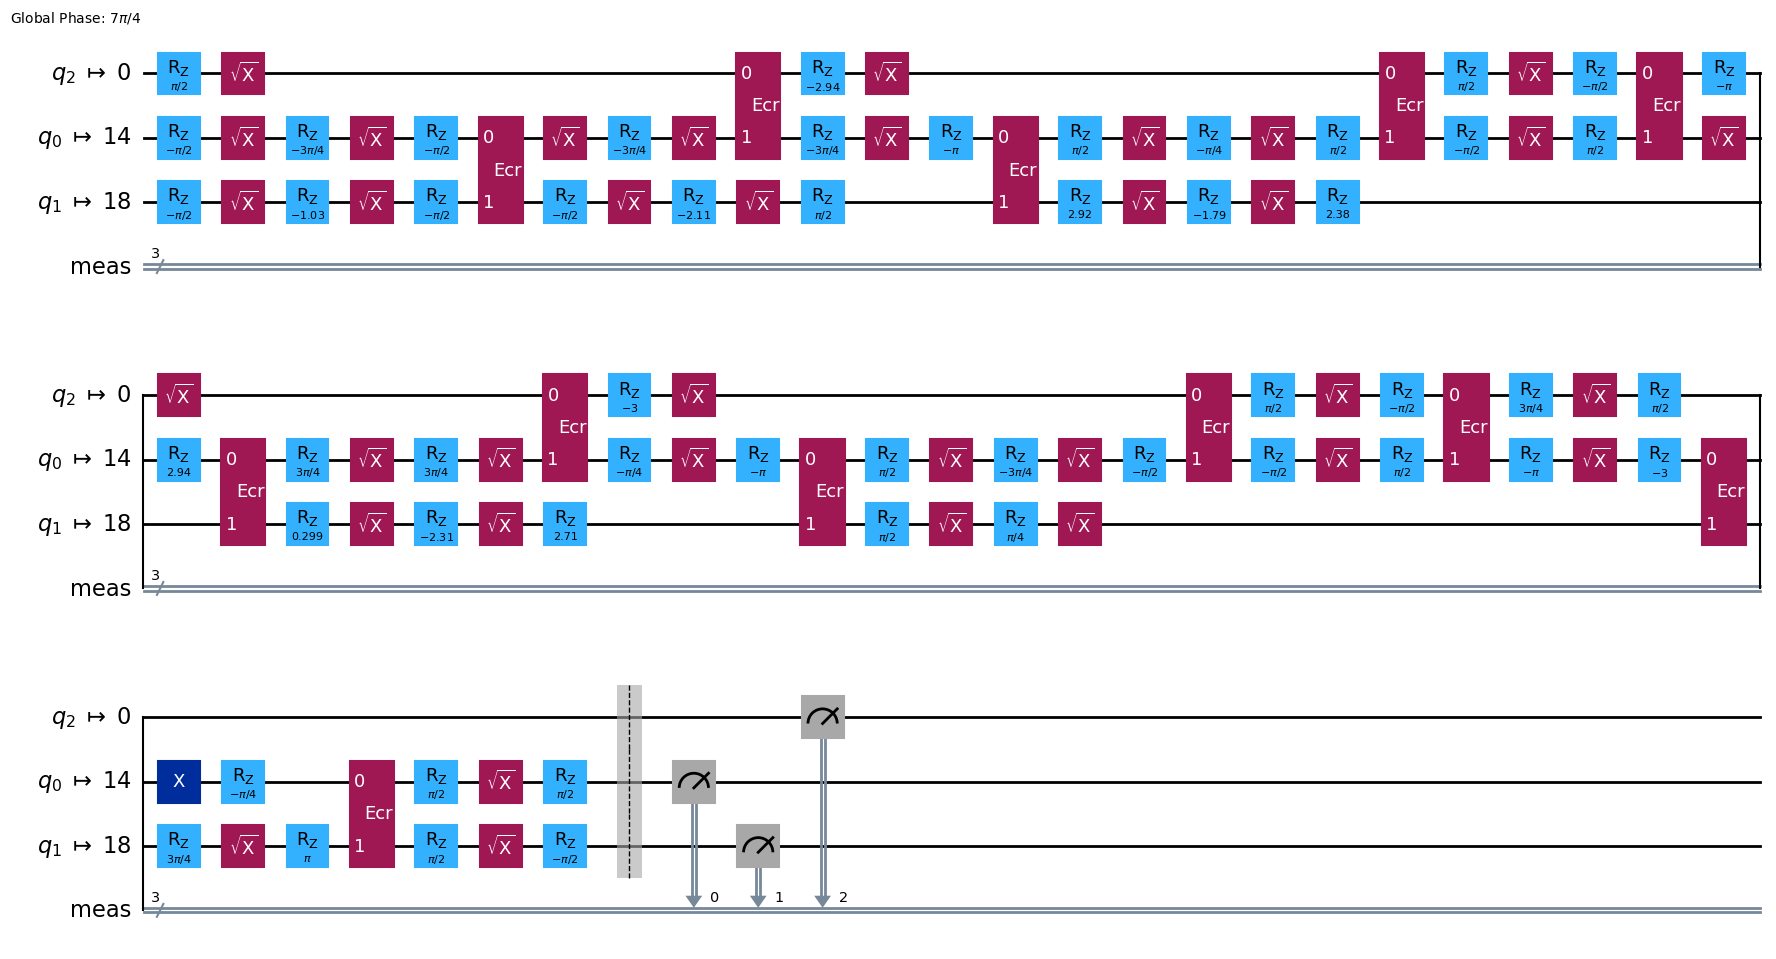

In [11]:
grover_qc.measure_all()

transpiled_grovers_qc = pm.run(grover_qc)
transpiled_grovers_qc.draw(output="mpl", idle_wires=False, style="iqp")

Figure 10.5: Transpiled Grover operator circuit (truncated)

In [12]:
# Create some random circuits with varying optimization levels
circuits = []

# Using the same circuit, transpile each to a different optimization level
for optimization_level in [0, 3]:
    transpiled_grover_qc = transpile(grover_qc, backend, optimization_level=optimization_level, seed_transpiler=1000)
    print(f"ECRs (optimization_level={optimization_level}): ", transpiled_grover_qc.count_ops()["ecr"])
    circuits.append(transpiled_grover_qc)

ECRs (optimization_level=0):  24
ECRs (optimization_level=3):  12


In [13]:
# Commented out by Alain Chancé
#with Batch(service=service, backend=backend):
#    sampler = Sampler()
#    job = sampler.run(
#        circuits=circuits,  # sample all three circuits
#        skip_transpilation=True,
#        shots=8000,
#    )
#    result = job.result()

In [14]:
# Modified by Alain Chancé
# https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/batch
from qiskit_ibm_runtime import Batch

pm = generate_preset_pass_manager(backend=backend)
isa_circuits = pm.run(circuits)

with Batch(backend=backend):
    sampler = Sampler()
    try:
        job = sampler.run(isa_circuits, shots=8000)
        result = job.result()
    except:
        print(sys.exc_info())

In [15]:
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=8000, num_bits=3>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=8000, num_bits=3>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-12 22:45:18', stop='2025-04-12 22:45:23', size=16000>)])}, 'version': 2})


In [16]:
# Commented out by Alain Chancé
#qc_results = [quasi_dist.binary_probabilities() for quasi_dist in result.quasi_dists]
#plot_histogram(
#    qc_results + [results],
#    legend=[
#        "optimization_level=0",
#        "optimization_level=3",
#        "Simulated results",
#    ],
#    bar_labels=False
#)

In [17]:
# Added by Alain Chancé
# Access result data for PUB 0
data_pub_0 = result[0].data
    
# Get counts for the classical register "meas"
# measure_all must be used with data.meas
# See Unexpected Error Thrown by StatevectorSampler #2219 - https://github.com/Qiskit/qiskit-aer/issues/2219
counts_0 = data_pub_0.meas.get_counts()
print(f"The counts are: {counts_0}")

The counts are: {'101': 432, '110': 4834, '001': 318, '100': 498, '000': 620, '010': 742, '011': 243, '111': 313}


In [18]:
# Added by Alain Chancé
# Access result data for PUB 1
data_pub_1 = result[1].data
    
# Get counts for the classical register "meas"
# measure_all must be used with data.meas
# measure_active must be used with data.measure
# See Unexpected Error Thrown by StatevectorSampler #2219 - https://github.com/Qiskit/qiskit-aer/issues/2219
counts_1 = data_pub_1.meas.get_counts()
print(f"The counts are: {counts_1}")

The counts are: {'001': 355, '110': 5520, '000': 360, '111': 505, '100': 308, '011': 312, '010': 328, '101': 312}


### Plot the quasi-distribution

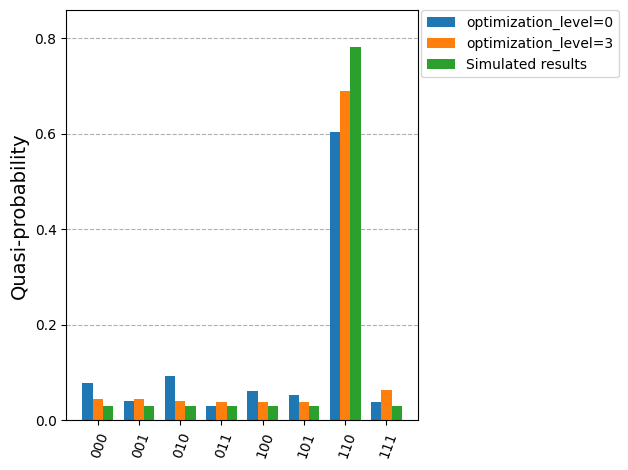

In [19]:
# Modified by Alain Chancé
# Create a histogram of the quasi-probability
plot_histogram(
[counts_0, counts_1, results],
legend=[
"optimization_level=0",
"optimization_level=3",
"Simulated results"
],
bar_labels=False
)

Figure 10.6: Post-processed results, visualization comparison

In [20]:
from qiskit.circuit.random import random_circuit

# Create a random circuit
qc2 = random_circuit(3, 3, measure=False)
qc2.draw(output='mpl')
results = Statevector.from_instruction(qc2).probabilities_dict()
#Add measurements to run on live system and get results: 
qc2.measure_all(add_bits=True)

In [21]:
# Modified by Alain Chancé
target = backend.target
pass_mgr = generate_preset_pass_manager(target=target, optimization_level=3)

transpiled_qc2 = pass_mgr.run(qc2)
circuits.append(transpiled_qc2)

isa_circuits = pm.run(circuits)

with Batch(backend=backend):
    sampler = Sampler()
    try:
        job = sampler.run(isa_circuits, shots=8000)
        result = job.result()
    except:
        print(sys.exc_info())

In [22]:
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=8000, num_bits=3>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=8000, num_bits=3>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=8000, num_bits=3>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-12 22:45:38', stop='2025-04-12 22:45:45', size=24000>)])}, 'version': 2})


In [23]:
# Commented out by Alain Chancé
#binary_prob = [quasi_dist.binary_probabilities() for quasi_dist in result.quasi_dists]
#plot_histogram(
#    binary_prob,
#    bar_labels=False,
#    legend=[
#        "optimization_level=0",
#        "optimization_level=3",
#        #"optimization_level=3 + dd",
#        "Simulated results",
#    ],
#)

In [24]:
# Modified by Alain Chancé
# Access result data for PUB 0
data_pub_0 = result[0].data
    
# Get counts for the classical register "meas"
# measure_all must be used with data.meas
# See Unexpected Error Thrown by StatevectorSampler #2219 - https://github.com/Qiskit/qiskit-aer/issues/2219
counts_0 = data_pub_0.meas.get_counts()
print(f"The counts are: {counts_0}")

The counts are: {'011': 753, '110': 4855, '111': 445, '010': 446, '001': 504, '000': 298, '101': 343, '100': 356}


In [25]:
# Added by Alain Chancé
# Access result data for PUB 1
data_pub_1 = result[1].data
    
# Get counts for the classical register "meas"
# measure_all must be used with data.meas
# See Unexpected Error Thrown by StatevectorSampler #2219 - https://github.com/Qiskit/qiskit-aer/issues/2219
counts_1 = data_pub_1.meas.get_counts()
print(f"The counts are: {counts_1}")

The counts are: {'011': 268, '110': 5604, '111': 285, '000': 386, '010': 488, '101': 231, '100': 410, '001': 328}


### Plot the quasi-distribution

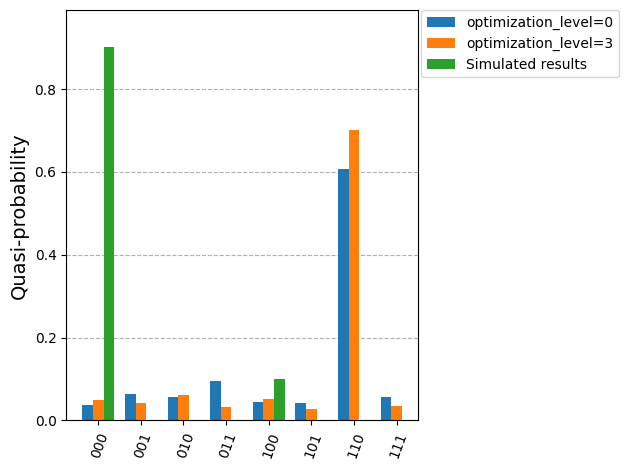

In [26]:
# Modified by Alain Chancé
# Create a histogram of the quasi-probability
plot_histogram(
[counts_0, counts_1, results],
legend=[
"optimization_level=0",
"optimization_level=3",
"Simulated results"
],
bar_labels=False
)

# Supressing and Mitigating Noise

# Error Suppression 

In [27]:
import numpy as np
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer

In [28]:
# Select the least busy system
backend = service.least_busy(simulator=False, operational=True)

# Added by Alain Chancé
target = backend.target

# Pull and print the duration times of the backend system for each gate per qubit:
dur = InstructionDurations.from_backend(backend)
print(dur)

ecr(0, 1): 5.617777777777778e-07 s
ecr(0, 14): 5.617777777777778e-07 s
ecr(1, 2): 5.617777777777778e-07 s
ecr(2, 3): 5.831111111111111e-07 s
ecr(4, 3): 5.617777777777778e-07 s
ecr(4, 15): 5.831111111111111e-07 s
ecr(5, 4): 5.617777777777778e-07 s
ecr(6, 5): 5.831111111111111e-07 s
ecr(7, 6): 5.617777777777778e-07 s
ecr(7, 8): 5.617777777777778e-07 s
ecr(8, 9): 5.617777777777778e-07 s
ecr(10, 9): 5.831111111111111e-07 s
ecr(10, 11): 5.617777777777778e-07 s
ecr(11, 12): 5.831111111111111e-07 s
ecr(13, 12): 5.617777777777778e-07 s
ecr(14, 18): 5.831111111111111e-07 s
ecr(16, 8): 5.831111111111111e-07 s
ecr(17, 12): 5.617777777777778e-07 s
ecr(17, 30): 5.617777777777778e-07 s
ecr(19, 18): 5.617777777777778e-07 s
ecr(20, 19): 5.831111111111111e-07 s
ecr(21, 20): 5.617777777777778e-07 s
ecr(21, 22): 5.831111111111111e-07 s
ecr(22, 15): 5.617777777777778e-07 s
ecr(22, 23): 5.617777777777778e-07 s
ecr(23, 24): 5.617777777777778e-07 s
ecr(24, 25): 5.617777777777778e-07 s
ecr(26, 16): 5.61777777

In [29]:
# Set the duration times for each gate.
custom_duration_times = InstructionDurations([('x', None, 100), 
                                              ('h', 0, 100),
                                              ("cx", [0, 1], 200), 
                                              ("cx", [1, 2], 200),  
                                              ("cx", [2, 3], 200),
                                              ("measure", None, 500
                                                  )])

# Print the timescales for each gate we set:
print(custom_duration_times)

x: 100 dt
measure: 500 dt
h(0,): 100 dt
cx(0, 1): 200 dt
cx(1, 2): 200 dt
cx(2, 3): 200 dt



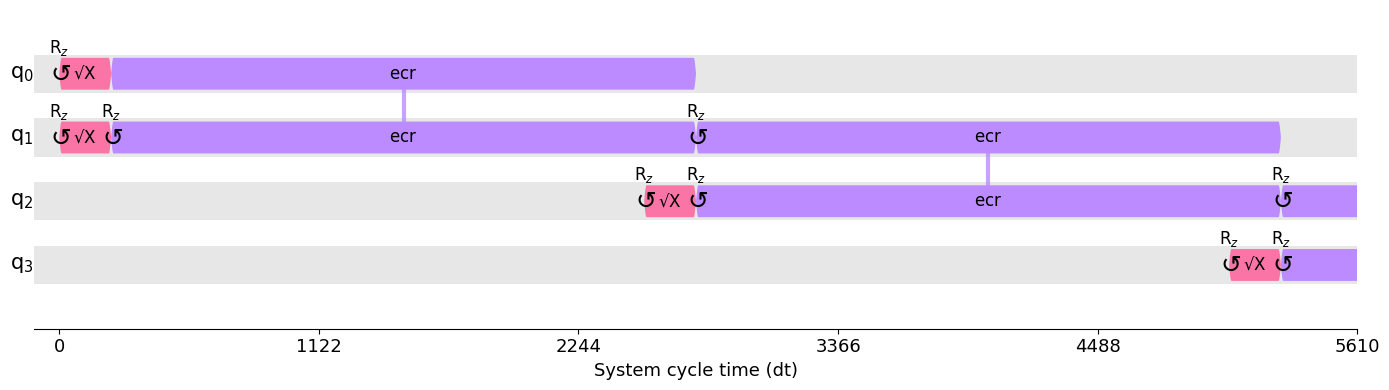

In [30]:
#Let's transpile and add specific scheduling and layout methods to the circuit we created at the start of this notebook 
#and view the default timeline
transpiled_qc = transpile(qc, backend, scheduling_method='alap', layout_method='trivial')
# Modified by Alain Chancé
#timeline_drawer(transpiled_qc, time_range=[0,5500], show_idle=False)
timeline_drawer(transpiled_qc, time_range=[0,5500], show_idle=False, target=target)

Figure 10.8: Circuit timeline visualization

In [31]:
# Create the Dynamical Decoupling sequence of reversible gates, let's use XGates:
rev_gates = [XGate(), XGate()]

# Set the PassManager with the Dynamical Decoupling sequence and custom duration times
pm = PassManager([ALAPScheduleAnalysis(custom_duration_times),
                  PadDynamicalDecoupling(custom_duration_times, rev_gates)])

In [32]:
# Run the circuit through the PassManager to add the DD to the transpiled circuit
# Modified by Alain Chancé
#qc_dynamical_decoupling = pm.run(transpiled_qc) 
try:
    qc_dynamical_decoupling = pm.run(transpiled_qc)
except:
    print(sys.exc_info())
    qc_dynamical_decoupling = None

(<class 'qiskit.transpiler.exceptions.TranspilerError'>, TranspilerError('Duration of measure on qubits [3] is not found.'), <traceback object at 0x7f45e11fa4c0>)


In [33]:
# Modified by Alain Chancé
#timeline_drawer(qc_dynamical_decoupling, show_idle=False)
if qc_dynamical_decoupling != None:
    display(timeline_drawer(qc_dynamical_decoupling, show_idle=False, target=target))

Figure 10.9: Visualization of the Dynamical Decoupling circuit

In [34]:
# Update durations
updated_values = [('x', None, 1500)]
updated_durations = custom_duration_times.update(updated_values)
print(updated_durations)

x: 1500 dt
measure: 500 dt
h(0,): 100 dt
cx(0, 1): 200 dt
cx(1, 2): 200 dt
cx(2, 3): 200 dt



In [35]:
# Create the Dynamical Decoupling sequence of reversible gates, let's use XGates:
#rev_gates = [XGate(), XGate()]

# Set the PassManager with the Dynamical Decoupling sequence and custom duration times
pm = PassManager([ALAPScheduleAnalysis(updated_durations),
                  PadDynamicalDecoupling(updated_durations, rev_gates)])

# Modified by Alain Chancé
try:
    qc_dynamical_decoupling = pm.run(transpiled_qc)
except:
    print(sys.exc_info())
    qc_dynamical_decoupling = None

# Modified by Alain Chancé
#timeline_drawer(qc_dynamical_decoupling, show_idle=False)
if qc_dynamical_decoupling != None:
    display(timeline_drawer(qc_dynamical_decoupling, show_idle=False, target=target))

(<class 'qiskit.transpiler.exceptions.TranspilerError'>, TranspilerError('Duration of measure on qubits [3] is not found.'), <traceback object at 0x7f45e11fa4c0>)


Figure 10.10: Visualization of circuit with updated duration times

# Applying Error Suppression and Error Mitigation 


In [36]:
#Retrieve the least busy device, filter using backend parameters
least_busy_backend = service.least_busy(simulator=False, operational=True, min_num_qubits=transpiled_qc.num_qubits)
backend = least_busy_backend
print('Least busy backend: ', least_busy_backend)

Least busy backend:  <IBMBackend('ibm_kyiv')>


## Create a simple circuit with measure_all()

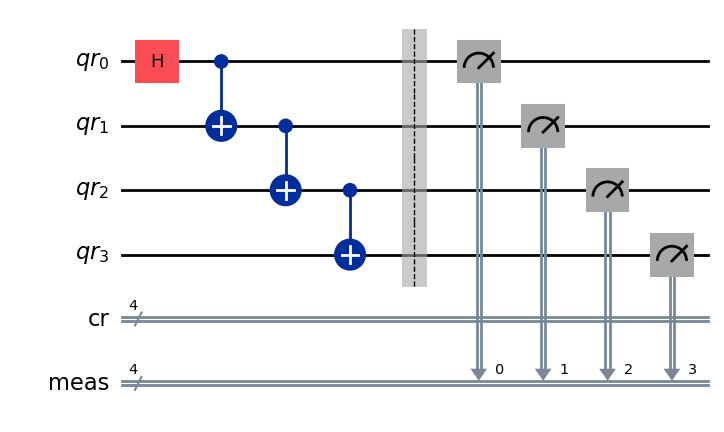

In [37]:
q_reg = QuantumRegister(4, name="qr")
c_reg = ClassicalRegister(4, name="cr")

qc = QuantumCircuit(q_reg, c_reg)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)

qc.measure_all()

qc.draw(output='mpl')

## Set the optimisation level to 0, no error suppression

In [38]:
# Commented out by Alain Chancé
#options = Options()
#options.execution.shots = 1000
#options.optimization_level = 0  # No error suppression
#options.resilience_level = 0  # No error mitigation

#with Session(service=service, backend=least_busy_backend) as session:
#    sampler = Sampler(session=session, options=options)
#    job_sim_0 = sampler.run(transpiled_qc)
#    print(job_sim_0.result())
#    session.close()

In [39]:
# Commented out by Alain Chancé
# Access result data for PUB 0
#data_pub = result[0].data
    
# Get counts for the classical register "meas"
#counts = data_pub.meas.get_counts()
#print(f"The counts are: {counts}")
    
#Create a histogram of the counts
#histogram = plot_distribution(counts)
#display(histogram)

In [40]:
# Initialize circuits
circuits = []

# Optimization level = 0
transpiled_qc = transpile(qc, backend, optimization_level=0, seed_transpiler=1000)
circuits.append(transpiled_qc)

In [41]:
# Added by Alain Chancé
# Migrate to the Qiskit Runtime V2 primitives
# https://docs.quantum.ibm.com/migration-guides/v2-primitives

pm = generate_preset_pass_manager(backend=backend)
isa_circuits = pm.run(circuits)

with Session(backend=backend):
    sampler = Sampler()
    try:
        job = sampler.run(isa_circuits, shots=1000)
        result = job.result()
    except:
        print(sys.exc_info())

In [42]:
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1000, num_bits=4>), meas=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-12 22:46:07', stop='2025-04-12 22:46:08', size=1000>)])}, 'version': 2})


The counts are: {'1100': 3, '0000': 437, '1111': 456, '0001': 12, '1000': 14, '1011': 4, '1110': 24, '0111': 11, '1010': 1, '1101': 12, '0010': 14, '0100': 3, '0011': 7, '0110': 2}


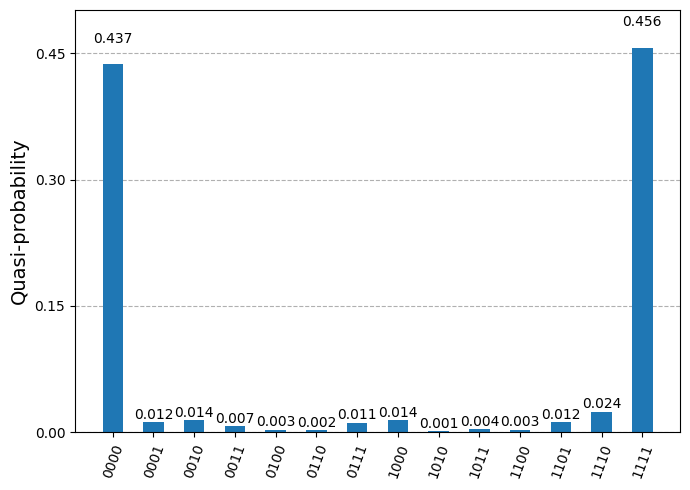

In [43]:
# Added by Alain Chancé
# Access result data for PUB 0
data_pub = result[0].data
    
# Get counts for the classical register "meas"
# measure_all must be used with data.meas
# See Unexpected Error Thrown by StatevectorSampler #2219 - https://github.com/Qiskit/qiskit-aer/issues/2219
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")
    
#Create a histogram of the counts
histogram = plot_distribution(counts)
display(histogram)

## Set the optimization level to 3, which will enable dynamical decoupling

In [44]:
# Commented out by Alain Chancé
#options = Options()
#options.execution.shots = 1000
#options.optimization_level = 3  # Levels 1-3 use Dynamical Decoupling
#options.resilience_level = 1  # Level 1 uses TREX for error mitigation

#with Session(service=service, backend=least_busy_backend) as session:
#    sampler = Sampler(session=session, options=options)
#    job_sim_1 = sampler.run(transpiled_qc)
#    print(job_sim_1.result())
#    session.close()

In [45]:
# Initialize circuits
circuits = []

# Set the optimization level to 3, which will enable dynamical decoupling
transpiled_qc = transpile(qc, backend, optimization_level=3, seed_transpiler=1000)
circuits.append(transpiled_qc)

In [46]:
# Added by Alain Chancé
# Migrate to the Qiskit Runtime V2 primitives
# https://docs.quantum.ibm.com/migration-guides/v2-primitives

pm = generate_preset_pass_manager(backend=backend)
isa_circuits = pm.run(circuits)

with Session(backend=backend):
    sampler = Sampler()
    try:
        job = sampler.run(isa_circuits, shots=1000)
        result = job.result()
    except:
        print(sys.exc_info())

In [47]:
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(cr=BitArray(<shape=(), num_shots=1000, num_bits=4>), meas=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-04-12 22:46:18', stop='2025-04-12 22:46:19', size=1000>)])}, 'version': 2})


The counts are: {'0011': 10, '0000': 457, '1111': 432, '0111': 9, '1101': 12, '0010': 15, '1100': 4, '0001': 21, '1000': 17, '1110': 18, '1011': 1, '0100': 2, '1001': 1, '0110': 1}


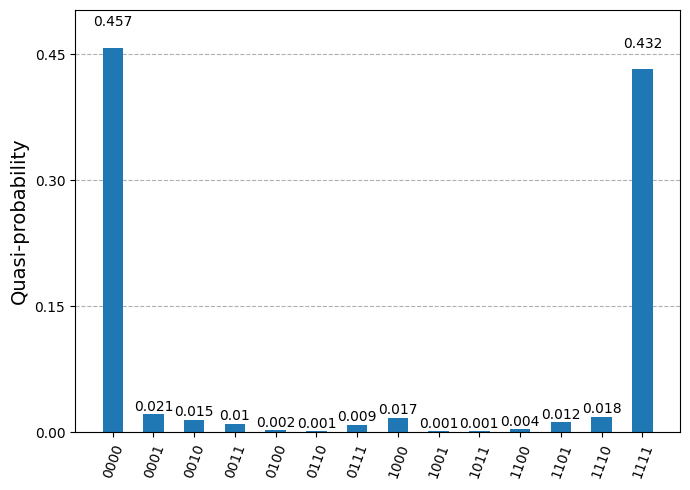

In [48]:
# Added by Alain Chancé
# Access result data for PUB 0
data_pub = result[0].data
    
# Get counts for the classical register "meas"
# measure_all must be used with data.meas
# See Unexpected Error Thrown by StatevectorSampler #2219 - https://github.com/Qiskit/qiskit-aer/issues/2219
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")
    
#Create a histogram of the counts
histogram = plot_distribution(counts)
display(histogram)

## Print Qiskit version

In [49]:
import qiskit
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.0.0


## Print Qiskit runtime version

In [50]:
import qiskit_ibm_runtime
print(f"Qiskit runtime version: {qiskit_ibm_runtime.__version__}")

Qiskit runtime version: 0.37.0


## Show Python version

In [51]:
%%bash
which python
python --version

/home/alain/miniconda3/bin/python
Python 3.12.9
